# DEA Experiment 1 Jupyter notebook demonstration

## Effects of using Landsat SWIR2 to estimate GVMI instead of Landsat SWIR1 in the implementation of CMRSET

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background

In a recent paper published in this journal, Bretreger et al. (2020, https://doi.org/10.1016/j.jhydrol.2020.125356) estimate irrigation water use (Irrest) from satellite remotely sensed estimates of actual evapotranspiration (ETa) in five irrigated districts of the Murray-Darling Basin (southeast Australia). In their paper, irrigation water use computed with CMRSET generally overestimated observed irrigation water use, sometimes fivefold. Based on these results, Bretreger et al. (2020) discouraged the use of CMRSET for irrigation monitoring. In this comment, we demonstrate that their overestimation was because they used an incorrect Landsat band in their implementation of CMRSET. CMRSET was originally calibrated using both MODIS-derived Enhanced Vegetation Index (EVI) and Global Vegetation Moisture Index (GVMI). To calculate GVMI a shortwave infrared (SWIR) band with a wavelength of ~1.6 μm was used, which for MODIS is named SWIR2, and for Landsat is named SWIR1 (i.e., different sensors have different bands and a different number of bands and SWIR1 in MODIS has a wavelength of ~1.2 μm). In their Landsat CMRSET implementation, Bretreger et al. (2020) computed GVMI using the Landsat SWIR2 band, which has a wavelength of ~2.1 μm (see their Table 3). We show that a Landsat CMRSET implementation using the incorrect Landsat band for the calculation of GVMI (i.e., with a wavelength of ~2.1 μm) led to a large overestimation of the crop factor (kc) agreeing with the CMRSET results reported by Bretreger et al. (2020). The use of the incorrect Landsat band means that the Bretreger et al. (2020) recommendation specific to their Landsat CMRSET implementation is incorrect. 

Here, a comparison of mean monthly Landsat 8 CMRSET’s (Guerschman et al., 2009, https://doi.org/10.1016/j.jhydrol.2009.02.013) with kc obtained using SWIR1 and SWIR2 in the computation of GVMI is shown. The hypothesis is that kc computed with SWIR2 is higher than with SWIR1, therefore ETa and Irrest are overestimated, supporting that Bretreger et al.'s (2020, ) implementation of CMRSET is flawed.

### Load packages


In [1]:
%matplotlib inline

import sys
import scipy.ndimage
import xarray
import numpy as np
import datacube
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
import rasterio
from datacube.utils.cog import write_cog
import matplotlib.pyplot as plt
from scipy.stats import kde

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb
from dea_tools.datahandling import dilate

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="L8_check_GVMI_SWIR1_SWIR2")

## Load Landsat 8 data from the datacube for an area in Wakool for the austral summer 2016-2017

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API with a pixel quality classification band called `oa_fmask`.


> **Note:** The `oa_fmask` pixel quality band contains categorical data. 
When loading this kind of data, it is important to use a resampling method that does not alter the values of the input cells.
In the example below, we resample `oa_fmask` data using the "nearest" method which preserves its original values. 
For all other bands with continuous values, we use "average" resampling.

In [3]:
# Create a query object
query = {
    'x': (144, 144.5),
    'y': (-35.5, -35), # Wakool subset
    "time": ("2016-12", "2017-02"), # summer

    "measurements": ["nbart_blue","nbart_green","nbart_red","nbart_nir","nbart_swir_1","nbart_swir_2","oa_fmask"],
    "output_crs": "EPSG:4326",
    "resolution": (-1/4800, 1/4800), # landsat resolution
    "group_by": "solar_day",
}

# Load available data from the Landsat 8 and masking using the oa_fmask
ds = dc.load(product="ga_ls8c_ard_3", resampling={"oa_fmask": "nearest", "*": "average"}, **query)

# Print output data
print(ds)

<xarray.Dataset>
Dimensions:       (time: 11, latitude: 2400, longitude: 2400)
Coordinates:
  * time          (time) datetime64[ns] 2016-12-03T00:15:20.661997 ... 2017-0...
  * latitude      (latitude) float64 -35.0 -35.0 -35.0 ... -35.5 -35.5 -35.5
  * longitude     (longitude) float64 144.0 144.0 144.0 ... 144.5 144.5 144.5
    spatial_ref   int32 4326
Data variables:
    nbart_blue    (time, latitude, longitude) int16 536 536 544 ... 513 444 457
    nbart_green   (time, latitude, longitude) int16 774 774 820 ... 750 636 648
    nbart_red     (time, latitude, longitude) int16 1063 1074 1096 ... 725 745
    nbart_nir     (time, latitude, longitude) int16 2075 2073 2187 ... 2181 2176
    nbart_swir_1  (time, latitude, longitude) int16 2875 2882 2944 ... 2099 2156
    nbart_swir_2  (time, latitude, longitude) int16 2188 2217 2153 ... 1361 1397
    oa_fmask      (time, latitude, longitude) uint8 1 1 1 1 1 1 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spati

### Creating the clear-pixel mask

We create a mask by specifying conditions that our pixels must satisfy.
But we will only need the labels (not the values) to create a mask.

In [4]:
# Create the mask based on "valid" pixels
clear_mask = make_mask(ds.oa_fmask, fmask="valid")
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = (
    make_mask(ds.oa_fmask, fmask="valid") | 
    make_mask(ds.oa_fmask, fmask="water") | 
    make_mask(ds.oa_fmask, fmask="snow")
)

# Apply the mask
ds = ds.where(cloud_free_mask)


## Show the Landsat 8 images in the composite

The plots below show the images available for the austral summer composite. White background means no data, either cloud, cloud-shadow or beyond the edge of the Landsat image. The date format shows year, month, day and time of the overpass in format `'YYYY-MM-DD HH:MM'`. 

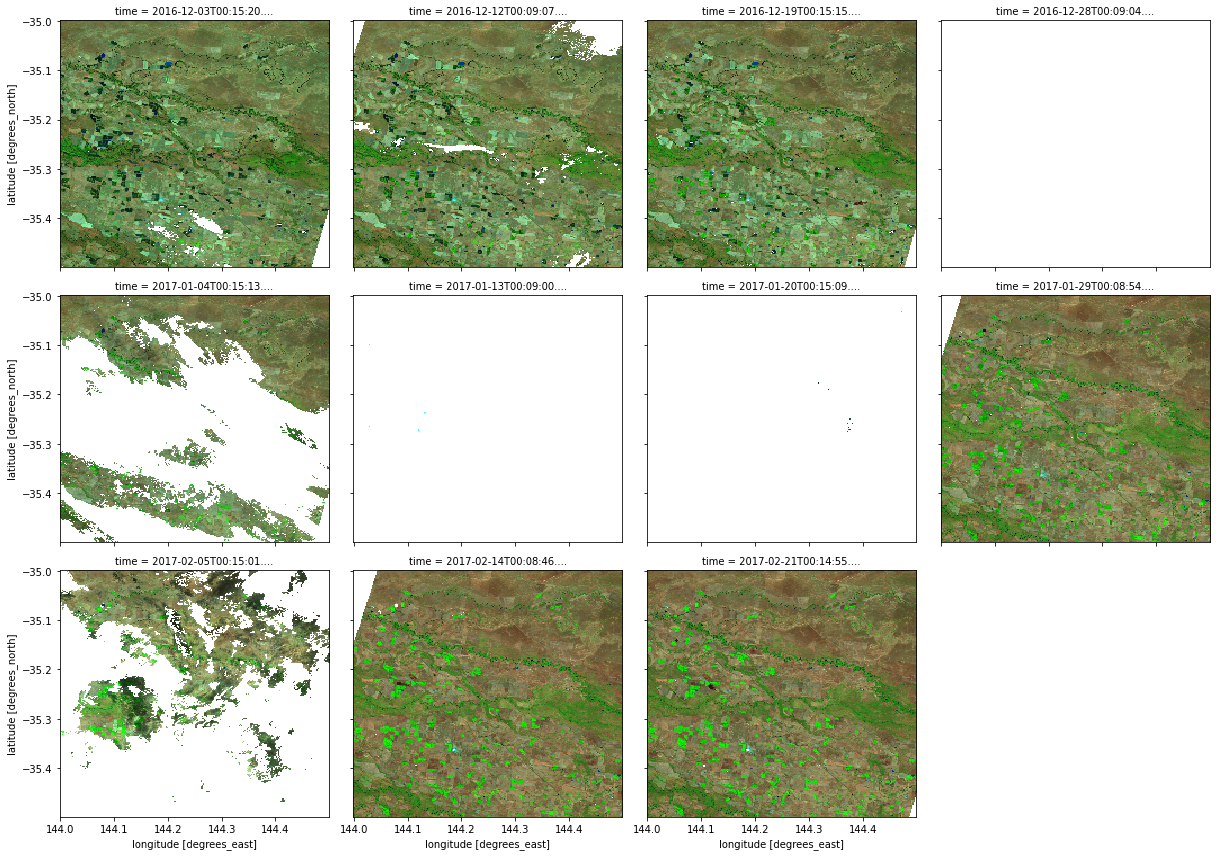

In [5]:
ds_plot = ds.sel(latitude=ds.latitude[0::10], longitude=ds.longitude[0::10])
ds_plot
ds_plot[['nbart_swir_2','nbart_nir','nbart_red']].to_array().plot.imshow(col='time', col_wrap=4, vmin=0, vmax=5000, size=4)

## Mean composites

A mean composite calculates the average value for each pixel, rather than using the middle value, as is done for a median composite. Unlike the median composite, the output from the mean composite calculation can contain pixel values that were not contained in of the original dataset. Care should be taken when interpreting mean composite images, as extreme values (such as unmasked cloud and unmasked cloud shadow, see the example above for 2017-02-05 or 5/Feb/2017 image) can strongly affect the resulting mean.

### Generating a single mean composite from all data

To generate a single mean composite, we use the `xarray.mean` method, specifying `'time'` as the dimension to compute the mean over.

> **Note**: If there are no valid values for a given pixel, you may see the warning:
`RuntimeWarning: Mean of empty slice`. The composite will still be generated, but may have blank areas.

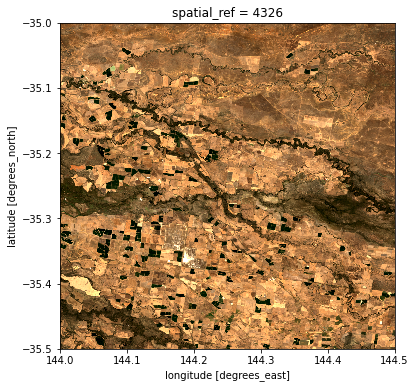

In [6]:
# Compute a single mean from all data
ds = ds.mean('time')

# View the resulting mean
rgb(ds)

## Calculate GVMI for this area using SWIR1 and SWIR2 and plot

The formula for GVMI is:

$$
\begin{aligned}
\text{GVMI} & = \frac{(\text{NIR}+0.1) - \text{(SWIR1}+0.02)}{(\text{NIR}+0.1) + (\text{SWIR1}+0.02)} \\
\end{aligned}
$$

GVMI is not part of the  `calculate_indices` function provided by GA as an easier way to calculate a wide range of remote sensing indices (for more information check the `dea_bandindices.py` tool), hence it needs to be calculated manually. If an index is applied to surface reflectance values in the 0-10000 range, unexpected results can occurr. Reflectance data needs to be normalised by dividing reflectance data by 10000. This is specified in line 112 of the `dea_bandindices.py` tool and in:

https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products?qt-news_science_products=0#qt-news_science_products

In the same way, we calculate GVMI with SWIR2.


Text(0.5, 1.0, 'GVMI with Landsat SWIR2')

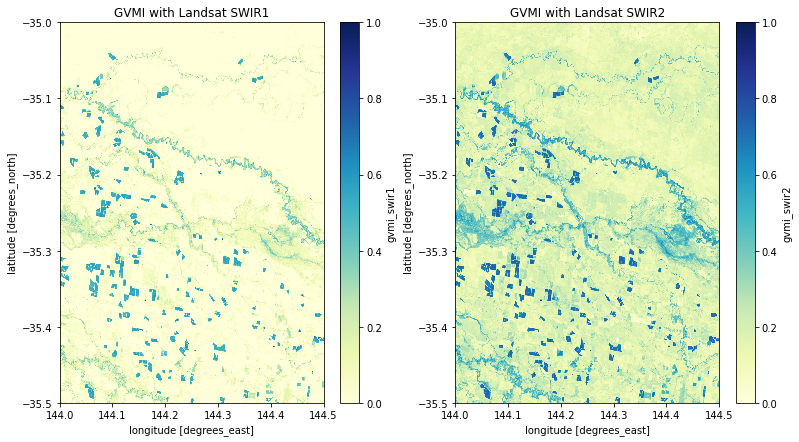

In [7]:
mult = 10000.0
ds['gvmi_swir1'] = np.minimum(np.maximum((((ds.nbart_nir/mult)+0.1)-((ds.nbart_swir_1/mult)+0.02))/\
    (((ds.nbart_nir/mult)+0.1)+((ds.nbart_swir_1/mult)+0.02)), 0), 1)

ds['gvmi_swir2'] = np.minimum(np.maximum((((ds.nbart_nir/mult)+0.1)-((ds.nbart_swir_2/mult)+0.02))/\
    (((ds.nbart_nir/mult)+0.1)+((ds.nbart_swir_2/mult)+0.02)), 0), 1)

# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Plot the results for GVMI with SWIR1 and GVMI with SWIR2:
ds.gvmi_swir1.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 0])
axarr[0, 0].set_title('GVMI with Landsat SWIR1')

ds.gvmi_swir2.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 1])
axarr[0, 1].set_title('GVMI with Landsat SWIR2')


We calculate the difference between GVMI with SWIR2 and GVMI with SWIR1 and plot.

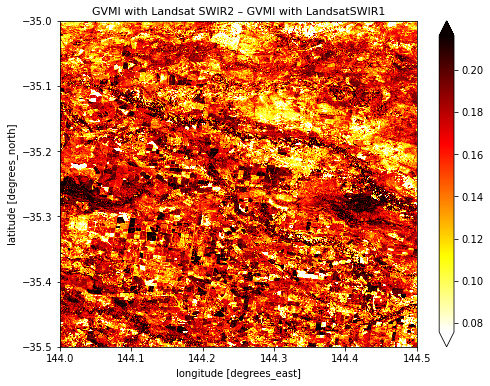

In [8]:
GVMI_diff=ds.gvmi_swir2-ds.gvmi_swir1

color_map = plt.cm.get_cmap('hot')
reversed_color_map = color_map.reversed()

GVMI_diff.plot(figsize=(8, 6),cmap=reversed_color_map,robust=True)
plt.title('GVMI with Landsat SWIR2 – GVMI with LandsatSWIR1', fontsize=11);

## Calculate EVI

In [9]:
mult = 10000.0
G = 2.5
C1 = 6
C2 = 7.5
L=1

ds['evi'] = np.minimum(np.maximum(G*(((ds.nbart_nir/mult))-((ds.nbart_red/mult)))/\
    ((ds.nbart_nir/mult) + C1*(ds.nbart_red/mult) - C2*(ds.nbart_blue/mult)+1), 0), 1)

## Calculate EVI rescaled

In [10]:
EVI_min = 0.0    
EVI_max = 0.90   

EVI_r = np.minimum(np.maximum(((ds.evi-EVI_min)/(EVI_max-EVI_min)), 0), 1)


## Calculate RMI with SWIR1 and with SWIR2

In [11]:
krmi = 0.775
crmi = -0.076

ds['rmi_swir1'] = np.maximum(0,ds.gvmi_swir1 - (krmi*ds.evi + crmi))
ds['rmi_swir2'] = np.maximum(0,ds.gvmi_swir2 - (krmi*ds.evi + crmi))


## Calculate kc with SWIR1 and with SWIR2 and plot

Text(0.5, 1.0, 'kc with Landsat SWIR2')

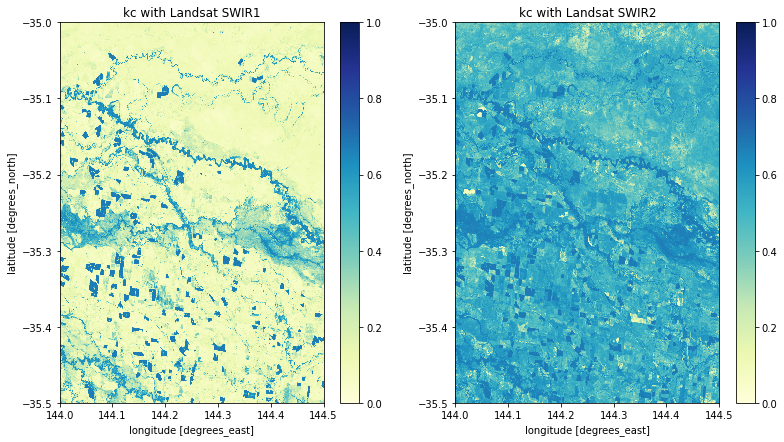

In [12]:
kc_max = 0.680
a = 14.12
alpha = 2.482
b = 7.991
beta = 0.890


kc_SWIR1 = kc_max * (1-np.exp(-a*(EVI_r**alpha)-b*(ds.rmi_swir1**beta)))

kc_SWIR2 = kc_max * (1-np.exp(-a*(EVI_r**alpha)-b*(ds.rmi_swir2**beta)))

# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Plot the results for GVMI with SWIR1 and GVMI with SWIR2:
kc_SWIR1.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 0])
axarr[0, 0].set_title('kc with Landsat SWIR1')

kc_SWIR2.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 1])
axarr[0, 1].set_title('kc with Landsat SWIR2')

We calculate the difference between kc calculated with GVMI with SWIR2 and GVMI with SWIR1 and plot.

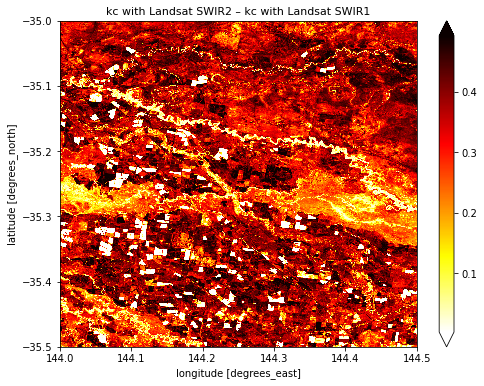

In [14]:
kc_diff=kc_SWIR2-kc_SWIR1

color_map = plt.cm.get_cmap('hot')
reversed_color_map = color_map.reversed()

kc_diff.plot(figsize=(8, 6),cmap=reversed_color_map,robust=True)
plt.title('kc with Landsat SWIR2 – kc with Landsat SWIR1', fontsize=11);

This example shows that indeed using the SWIR2 band in the computation of GVMI and subsequently kc, **will** produce an overstimation of actual evapotranspiration in CMRSET. Below a histogram of a subset of the above images. 

Text(0.5, 1.0, 'kc with Landsat SWIR2')

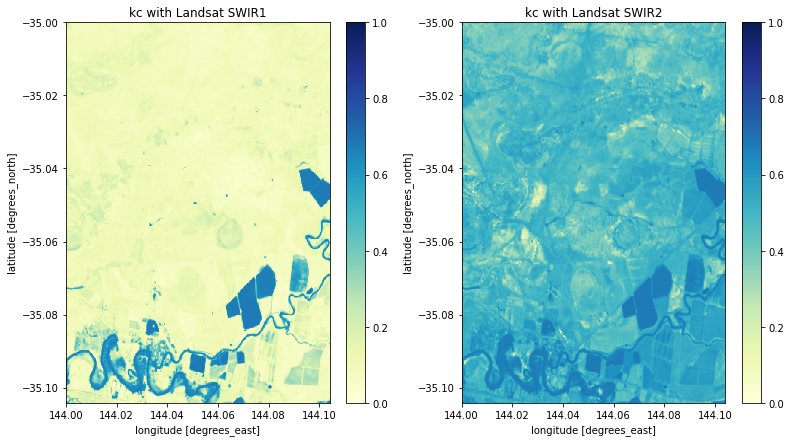

In [15]:
kc_SWIR1_subset = kc_SWIR1[0:500, 0:500]

kc_SWIR2_subset = kc_SWIR2[0:500, 0:500]

# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Plot the results for GVMI with SWIR1 and GVMI with SWIR2:
kc_SWIR1_subset.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 0])
axarr[0, 0].set_title('kc with Landsat SWIR1')

kc_SWIR2_subset.plot(vmin=0, vmax=1, cmap='YlGnBu',ax=axarr[0, 1])
axarr[0, 1].set_title('kc with Landsat SWIR2')

Text(0.5, 1.0, 'kc with Landsat SWIR2')

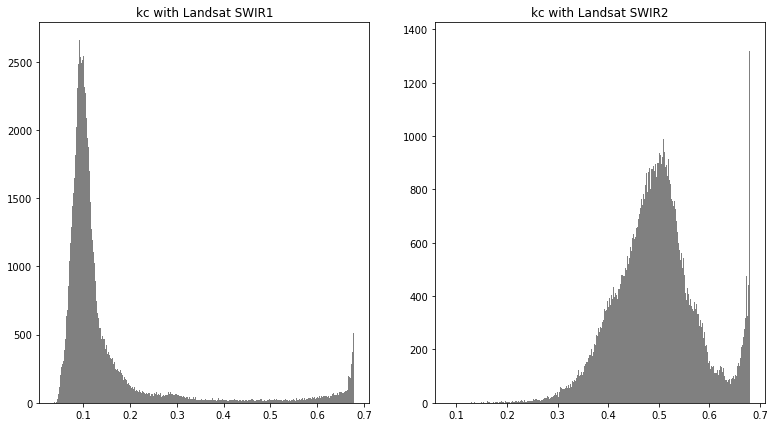

In [16]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Plot the results for GVMI with SWIR1 and GVMI with SWIR2:
kc_SWIR1_subset.plot.hist(ax=axarr[0, 0], bins=1000, facecolor='gray')
axarr[0, 0].set_title('kc with Landsat SWIR1')

kc_SWIR2_subset.plot.hist(ax=axarr[0, 1], bins=1000, facecolor='gray')
axarr[0, 1].set_title('kc with Landsat SWIR2')

Below a scatterplot of a subset of the above images. 

Text(0.5, 0, 'kc with Landsat SWIR1')

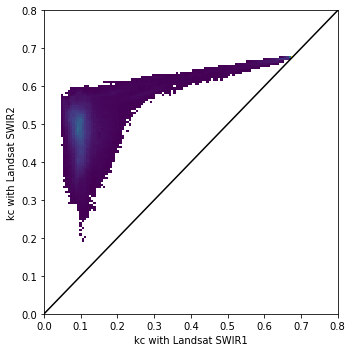

In [17]:
x=kc_SWIR1_subset.values.ravel() 
y=kc_SWIR2_subset.values.ravel()  

fig, axes = plt.subplots(figsize=(5,5), tight_layout=True) 

axes.hist2d(x,y, bins=100, cmap='viridis', cmin=1, density=True) 
axes.plot([0,1], [0,1], color='k')
axes.set_xlim(0,0.8)
axes.set_ylim(0,0.8)
axes.set_ylabel('kc with Landsat SWIR2')
axes.set_xlabel('kc with Landsat SWIR1')


## Conclusion

The large overestimation of estimated irrigation water use (Irrest) obtained with CMRSET actual evapotranspiration (ETa) estimates in Bretreger et al. (2020) arises not because of the unsuitability or low accuracy of the CMRSET model which was calibrated using MODIS data, but due to how they incorrectly implemented CMRSET with Landsat data. We show that the results of Bretreger et al. (2020) are incorrect, and demonstrated their error of assuming that MODIS bands were equivalent to Landsat bands. Originally, CMRSET was calibrated using the Global Vegetation Moisture Index (GVMI) using the MODIS SWIR2 band (with a wavelength of ~1.6 μm), yet in their Landsat CMRSET implementation, Bretreger et al. (2020) computed GVMI using the Landsat SWIR2 band (which has a wavelength of ~2.1 μm; see their Table 3), when they should have used the Landsat SWIR1 band (with a wavelength of ~1.6 μm, which is equivalent to the MODIS SWIR2 band). We demonstrated that kc computed with SWIR2 is higher than with SWIR1, therefore ETa and Irrest are overestimated, supporting that Bretreger et al.'s (2020) implementation of CMRSET is flawed.